<h2><center> Rock, Paper, Scissors and Santa-2020: ranking stability (EDA) </center></h2>

<h2><center> <img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/Csm_Brownian-Motion_f99de6516a.png" alt="Equilibrium img"></center></h2>

2 Feb 2021 submissions have been closed for both *Rock, Paper, Scissors (RPS)* and *Santa-2020* competitions. There is a 21-day evaluation period to reach stable rankings. This notebook aims to research how close are rankings to equilibrium (or something like it). It follows my previous EDA for [RPS](https://www.kaggle.com/demche/rock-paper-scissors-leaderboard-eda) and [Santa-2020](https://www.kaggle.com/demche/santa-2020-who-s-lucky-eda).

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_environments import (evaluate, make, utils, get_episode_replay, list_episodes)
from datetime import datetime, date
import gc
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 200)
pd.options.display.float_format = '{:,.2f}'.format

Loading environment football failed: No module named 'gfootball'


In [2]:
episodes = pd.read_csv("../input/meta-kaggle/Episodes.csv")
episodes["CreateTime"] = pd.to_datetime(episodes["CreateTime"], format="%m/%d/%Y %H:%M:%S")
episodes["EndTime"] = pd.to_datetime(episodes["EndTime"], format="%m/%d/%Y %H:%M:%S")
episode_agents = pd.read_csv("../input/meta-kaggle/EpisodeAgents.csv")
santa_df = pd.merge(episode_agents, episodes.loc[episodes["CompetitionId"] == 24539], left_on="EpisodeId", right_on="Id")
rps_df = pd.merge(episode_agents, episodes.loc[episodes["CompetitionId"] == 22838], left_on="EpisodeId", right_on="Id")
santa_df = santa_df.drop(columns=["Id_x", "Index", "Reward", "State", "Id_y", "Type", "CompetitionId"])
rps_df = rps_df.drop(columns=["Id_x", "Index", "Reward", "State", "Id_y", "Type", "CompetitionId"])

episodes_to_consider = episode_agents[episode_agents["EpisodeId"].isin(episodes["Id"].loc[episodes["CompetitionId"].isin([24539, 22838])])].\
    groupby(["SubmissionId"])["EpisodeId"].max().to_list()
del episodes, episode_agents
agents_mapping = pd.DataFrame(columns = ["TeamId", "SubmissionId", "submission_dt"])
for i in range(0, len(episodes_to_consider), 1000):
    batch = episodes_to_consider[i:i + 1000]
    try:
        resp = list_episodes(batch)  
        for episode in resp["result"]["submissions"]:
            agents_mapping = agents_mapping.append({"TeamId": episode["teamId"],
                                                    "SubmissionId":  episode["id"],
                                                    "submission_dt": datetime.strptime(episode["dateSubmitted"][:19], "%Y-%m-%dT%H:%M:%S")
                               }, ignore_index=True)
        del episode, batch
    except Exception as ex:
        print("Error:", ex)
        continue

santa_df = pd.merge(santa_df, agents_mapping, on="SubmissionId") 
rps_df = pd.merge(rps_df, agents_mapping, on="SubmissionId")
del episodes_to_consider, agents_mapping
santa_df = santa_df.drop_duplicates(subset=["EpisodeId"], keep='last')
rps_df = rps_df.drop_duplicates(subset=["EpisodeId"], keep='last')
gc.collect()

!wget "https://www.kaggle.com/c/rock-paper-scissors/leaderboard.json?includeBeforeUser=true&includeAfterUser=false" -O leaderboard_rps.json
with open("leaderboard_rps.json") as f:
    jsn = json.load(f)
!rm leaderboard_rps.json
leaderboard_rps = pd.DataFrame(columns = ["team_name", "team_id", "final_score", "n_agents"])
for user in jsn["beforeUser"]+jsn["afterUser"]:
    leaderboard_rps = leaderboard_rps.append({"team_name": user["teamName"], 
                                      "team_id": user["teamId"], 
                                      "final_score": user["score"], 
                                      "n_agents": user["entries"]}, 
                                     ignore_index=True)
leaderboard_rps[["score", "n_agents"]] = leaderboard_rps[["final_score", "n_agents"]].apply(pd.to_numeric)
leaderboard_rps["final_score"] = leaderboard_rps["final_score"].apply(pd.to_numeric, errors='coerce')
leaderboard_rps["team_rank"] = leaderboard_rps["final_score"].rank(method='dense', ascending=False).astype(int)
rps_df = pd.merge(rps_df, leaderboard_rps.drop(columns=["final_score", "n_agents"]), left_on="TeamId", right_on="team_id", how="left")
rps_df = rps_df.drop(columns=["team_id"])
gc.collect()

!wget "https://www.kaggle.com/c/santa-2020/leaderboard.json?includeBeforeUser=true&includeAfterUser=false" -O leaderboard_santa.json
with open("leaderboard_santa.json") as f:
    jsn = json.load(f)
!rm leaderboard_santa.json
leaderboard_santa = pd.DataFrame(columns = ["team_name", "team_id", "final_score", "n_agents"])
for user in jsn["beforeUser"]+jsn["afterUser"]:
    leaderboard_santa = leaderboard_santa.append({"team_name": user["teamName"], 
                                      "team_id": user["teamId"], 
                                      "final_score": user["score"], 
                                      "n_agents": user["entries"]}, 
                                     ignore_index=True)
leaderboard_santa[["score", "n_agents"]] = leaderboard_santa[["final_score", "n_agents"]].apply(pd.to_numeric)
leaderboard_santa["final_score"] = leaderboard_santa["final_score"].apply(pd.to_numeric, errors='coerce')
leaderboard_santa["team_rank"] = leaderboard_santa["final_score"].rank(method='dense', ascending=False).astype(int)
santa_df = pd.merge(santa_df, leaderboard_santa.drop(columns=["final_score", "n_agents"]), left_on="TeamId", right_on="team_id", how="left")
santa_df = santa_df.drop(columns=["team_id"])
gc.collect()

santa_df["date"] = santa_df["CreateTime"].dt.date
rps_df["date"] = rps_df["CreateTime"].dt.date

--2021-03-02 16:14:22--  https://www.kaggle.com/c/rock-paper-scissors/leaderboard.json?includeBeforeUser=true&includeAfterUser=false
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘leaderboard_rps.json’

leaderboard_rps.jso     [  <=>               ] 708.48K  1.88MB/s    in 0.4s    

2021-03-02 16:14:23 (1.88 MB/s) - ‘leaderboard_rps.json’ saved [725484]

--2021-03-02 16:14:39--  https://www.kaggle.com/c/santa-2020/leaderboard.json?includeBeforeUser=true&includeAfterUser=false
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘leaderboard_santa.json’

leaderboard_santa.j     [  <=>               ] 358.78K  1.16MB/s    i

# 1. Rankings volatility

Core idea: let's build team ranking for each period from 2 February to now (with 15-minute interval). Then, calculate the range between minimum and maximum team rank within one day.

In [3]:
interval = "15min"

santa_ranking = pd.DataFrame(columns = ["team_name", "score", "rank", "dtime"])
for dtime in pd.date_range(start=pd.to_datetime('2021-02-02', format='%Y-%m-%d'), end=santa_df["EndTime"].max(), freq=interval).tolist():
    new = santa_df[(santa_df["EndTime"] <= dtime) & (santa_df["EndTime"] >= (dtime - pd.Timedelta(hours=24)))].reset_index(drop=True)
    new = new.iloc[new.groupby("SubmissionId")["EndTime"].idxmax()].groupby(["team_name"], sort=False)["UpdatedScore"].max().reset_index()
    new["rank"] = new["UpdatedScore"].dropna().rank(method="max", ascending=False).astype(int)
    new = new.rename(columns={"UpdatedScore": "score"})
    new["dtime"] = dtime
    santa_ranking = santa_ranking.append(new, ignore_index = True)
    del new
santa_ranking["date"] = santa_ranking["dtime"].dt.date
santa_ranking["rank"] = santa_ranking["rank"].apply(pd.to_numeric, errors='coerce')
gc.collect()

rps_ranking = pd.DataFrame(columns = ["team_name", "score", "rank", "dtime"])
for dtime in pd.date_range(start=pd.to_datetime('2021-02-02', format='%Y-%m-%d'), end=rps_df["EndTime"].max(), freq=interval).tolist():
    new = rps_df[(rps_df["EndTime"] <= dtime) & (rps_df["EndTime"] >= (dtime - pd.Timedelta(hours=24)))].reset_index(drop=True)
    new = new.iloc[new.groupby("SubmissionId")["EndTime"].idxmax()].groupby(["team_name"], sort=False)["UpdatedScore"].max().reset_index()
    new["rank"] = new["UpdatedScore"].dropna().rank(method="max", ascending=False).astype(int)
    new = new.rename(columns={"UpdatedScore": "score"})
    new["dtime"] = dtime
    rps_ranking = rps_ranking.append(new, ignore_index = True)
    del new
rps_ranking["date"] = rps_ranking["dtime"].dt.date
rps_ranking["rank"] = rps_ranking["rank"].apply(pd.to_numeric, errors='coerce')
gc.collect()

28

In [4]:
rps = rps_ranking.groupby(["team_name","date"]).agg({"rank": [np.ptp, np.std]}).reset_index()
rps.columns = rps.columns.droplevel()
rps.columns = ["team_name", "date", "RPS_rank_range", "RPS_rank_std"]
rps = rps.groupby(["date"]).agg({"RPS_rank_range": np.mean, "RPS_rank_std": np.mean})
santa = santa_ranking.groupby(["team_name","date"]).agg({"rank": [np.ptp, np.std]}).reset_index()
santa.columns = santa.columns.droplevel()
santa.columns = ["team_name", "date", "Santa_rank_range", "Santa_rank_std"]
santa = santa.groupby(["date"]).agg({"Santa_rank_range": np.mean, "Santa_rank_std": np.mean})
date_stat = pd.merge(rps, santa, on="date").dropna()
del rps, santa

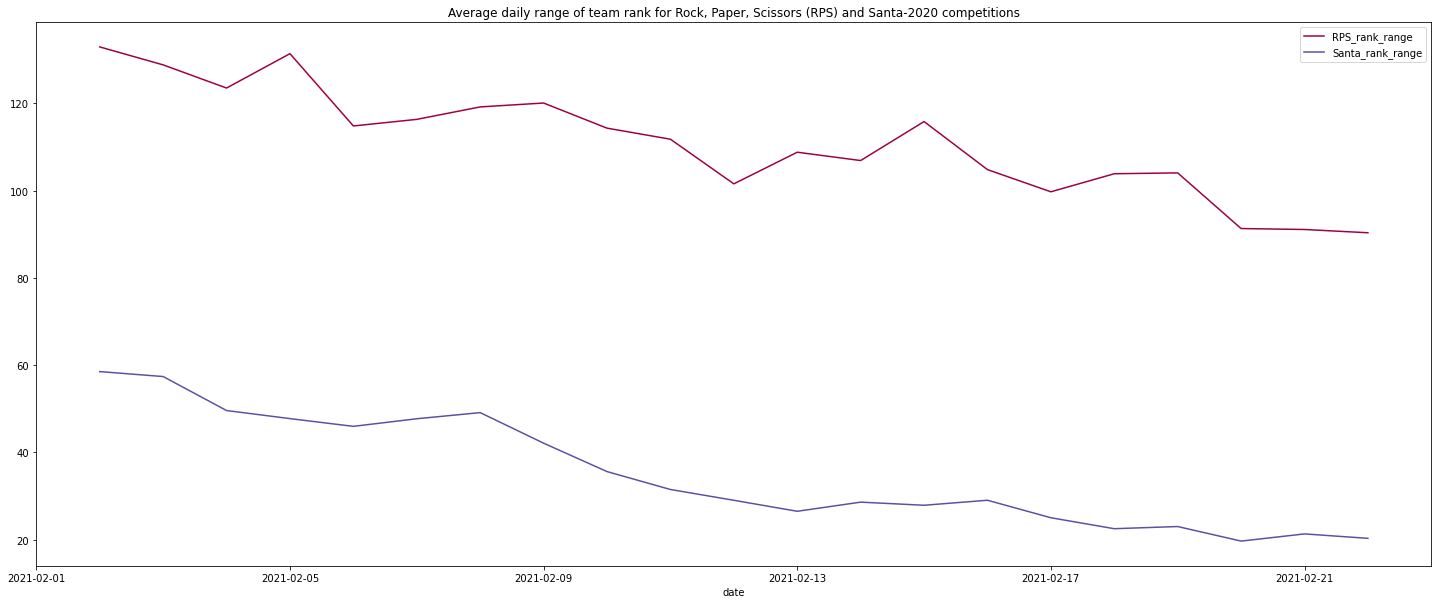

In [5]:
date_stat.drop(columns=["RPS_rank_std", "Santa_rank_std"]).plot(figsize=(25,10), cmap="Spectral",
               title="Average daily range of team rank for Rock, Paper, Scissors (RPS) and Santa-2020 competitions")
plt.show()

Instead of range, we can use standard deviation:

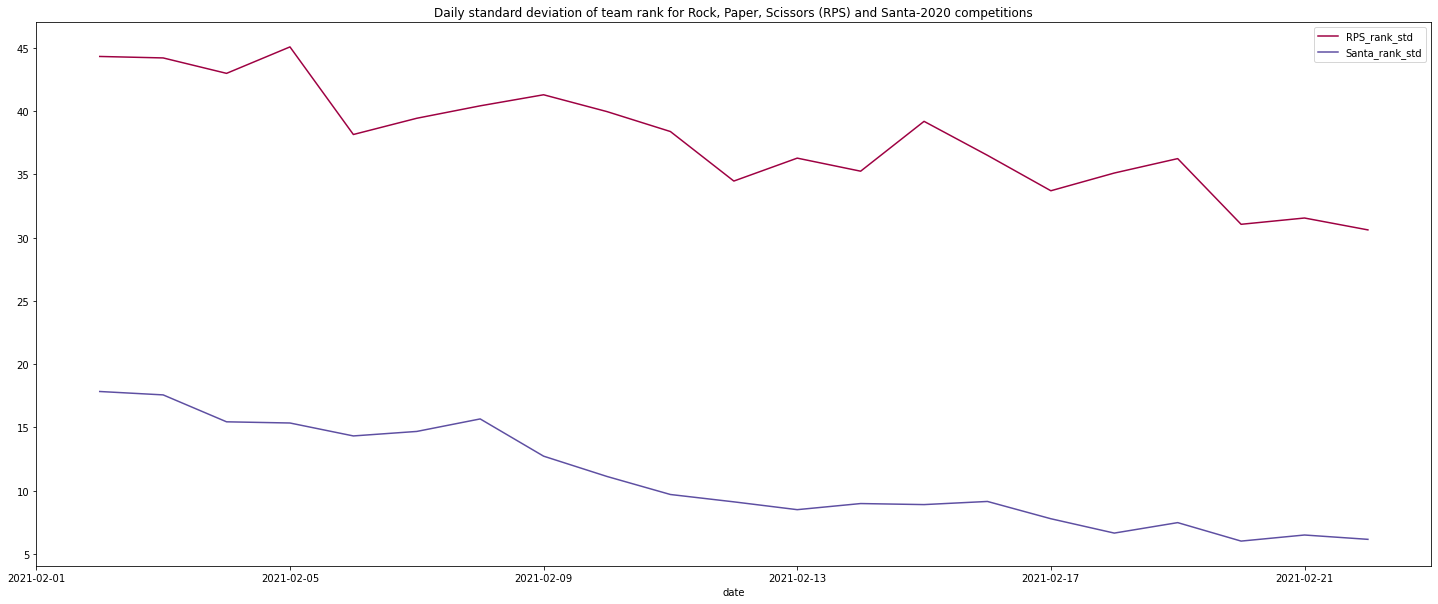

In [6]:
date_stat.drop(columns=["RPS_rank_range", "Santa_rank_range"]).plot(figsize=(25,10), cmap="Spectral",
               title="Daily standard deviation of team rank for Rock, Paper, Scissors (RPS) and Santa-2020 competitions")
plt.show()

# 2. Current vs highest team rank

How did the team rank change during the evaluation period?

### 2.1 Santa-2020

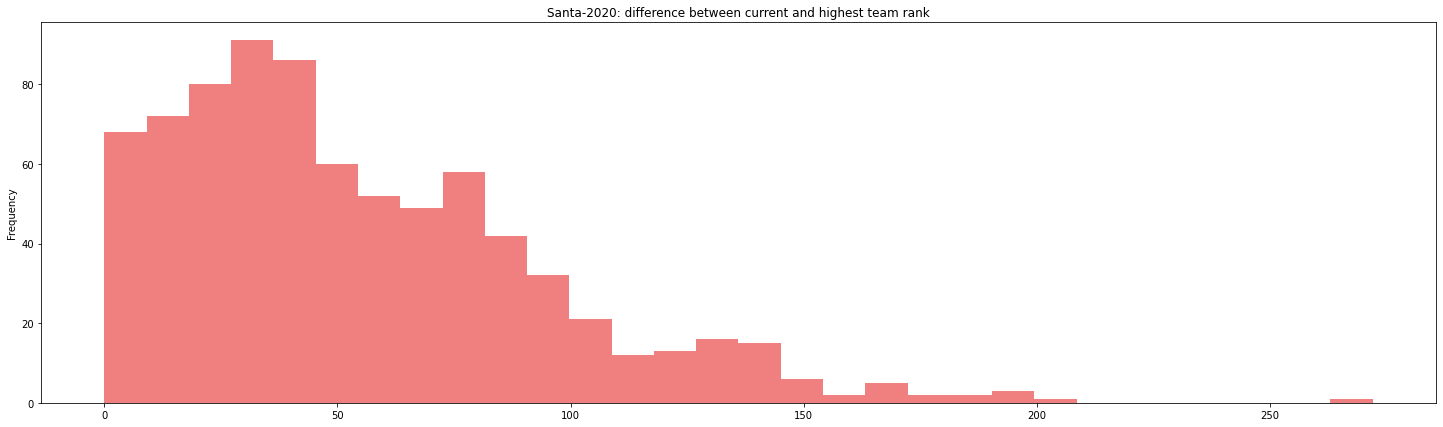

In [7]:
team_brkdn_santa = pd.merge(leaderboard_santa.loc[:, ["team_name", "team_rank"]].rename(columns={"team_rank": "current_rank"}),
         santa_ranking.groupby(["team_name"])["rank"].min().reset_index().rename(columns={"rank": "highest_rank"}), on="team_name")
team_brkdn_santa["highest_rank"] = team_brkdn_santa.apply(lambda x: x["current_rank"] if x["current_rank"] < x["highest_rank"] else x["highest_rank"], axis=1)
team_brkdn_santa["highest rank - current rank"] = team_brkdn_santa["current_rank"] - team_brkdn_santa["highest_rank"]
team_brkdn_santa["highest rank - current rank"] = team_brkdn_santa["highest rank - current rank"].apply(pd.to_numeric, errors='coerce')
team_brkdn_santa["highest rank - current rank"].plot(kind="hist", figsize=(25,7), color="lightcoral", bins=30, 
                                                     title="Santa-2020: difference between current and highest team rank")
plt.show()

In [8]:
team_brkdn_santa.sort_values(by=["current_rank"]).reset_index(drop=True).head(200).\
    style.background_gradient(subset=["highest rank - current rank"], cmap="Wistia")

,team_name,current_rank,highest_rank,highest rank - current rank
0,nagiss 🦌,1,1.000000,0.000000
1,kibuna,2,1.000000,1.000000
2,Coffee Candy ☕,3,1.000000,2.000000
3,Dmitriy Guller,4,1.000000,3.000000
4,(⊙﹏⊙),5,2.000000,3.000000
5,woody285,6,2.000000,4.000000
6,Xrc,7,4.000000,3.000000
7,TBD,8,2.000000,6.000000
8,toshi_k,9,2.000000,7.000000
9,Kun Hao Yeh,10,3.000000,7.000000


### 2.2 Rock, Paper, Scissors

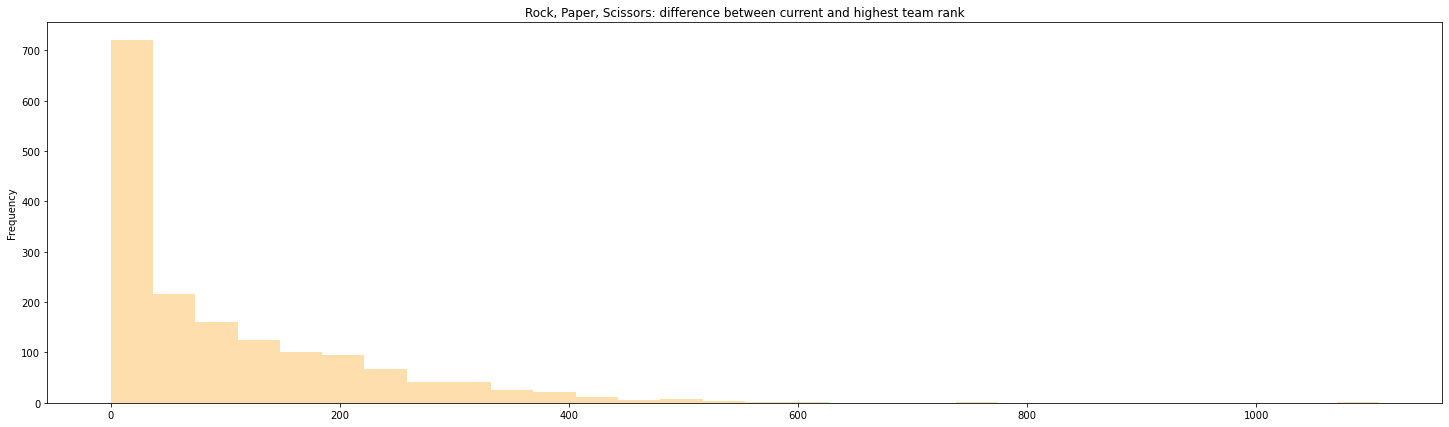

In [9]:
team_brkdn_rps = pd.merge(leaderboard_rps.loc[:, ["team_name", "team_rank"]].rename(columns={"team_rank": "current_rank"}),
         rps_ranking.groupby(["team_name"])["rank"].min().reset_index().rename(columns={"rank": "highest_rank"}), on="team_name")
team_brkdn_rps["highest_rank"] = team_brkdn_rps.apply(lambda x: x["current_rank"] if x["current_rank"] < x["highest_rank"] else x["highest_rank"], axis=1)
team_brkdn_rps["highest rank - current rank"] = team_brkdn_rps["current_rank"] - team_brkdn_rps["highest_rank"]
team_brkdn_rps["highest rank - current rank"].plot(kind="hist", figsize=(25,7), color="navajowhite", bins=30, 
                                                     title="Rock, Paper, Scissors: difference between current and highest team rank")
plt.show()

In [10]:
team_brkdn_rps.sort_values(by=["current_rank"]).reset_index(drop=True).head(200).\
    style.background_gradient(subset=["highest rank - current rank"], cmap="Wistia")

,team_name,current_rank,highest_rank,highest rank - current rank
0,Where is my bag,1,1,0
1,Georg Streich,2,1,1
2,Stas Sl,3,1,2
3,Taaha Khan,4,1,3
4,mike h,5,2,3
5,つ ◕_◕ ༽つTAKE MY ENERGY ༼ つ ◕_◕ ༽つ,6,2,4
6,Charles-Eric,6,4,2
7,じゃんけんぽん太,7,5,2
8,💯,8,7,1
9,John TerMaat,9,1,8


# 3. Agent score volatility

Ranking volatility comes from the volatility of individual agents:

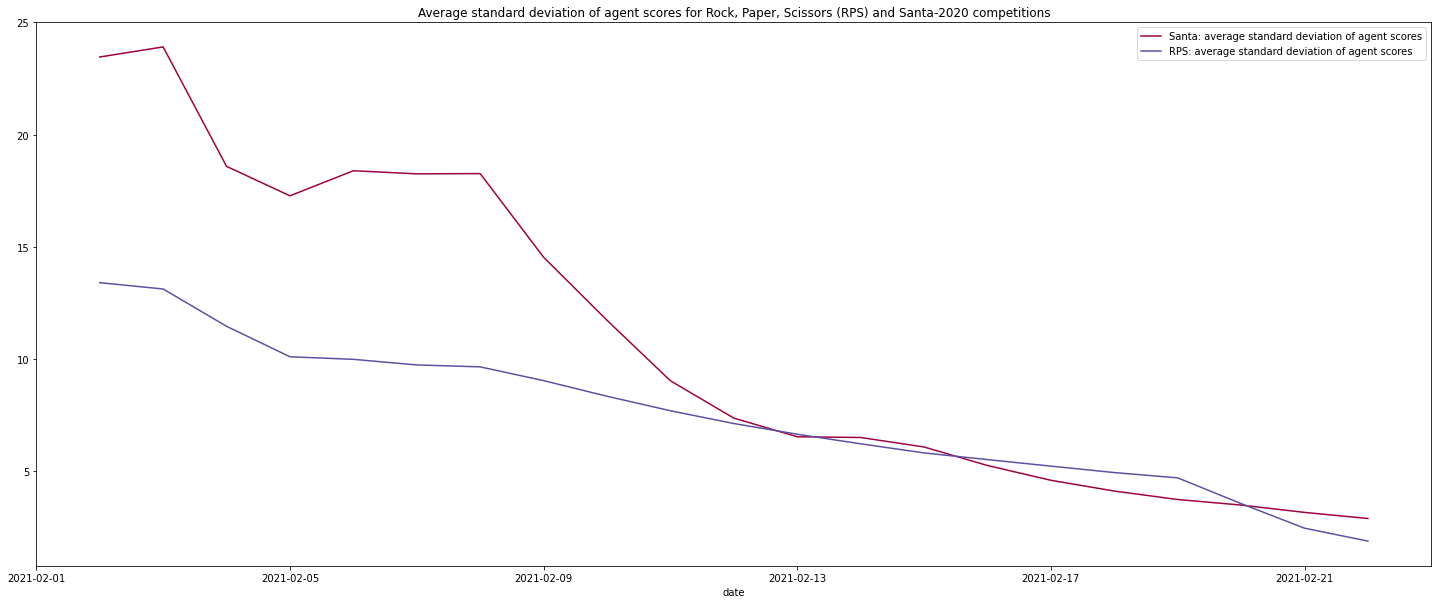

In [11]:
date_stat_agent = pd.merge(
        santa_df[santa_df["CreateTime"] >= pd.to_datetime('2021-02-02', format='%Y-%m-%d')].\
            groupby(["SubmissionId", "date"])["UpdatedScore"].std().reset_index().\
            groupby("date")["UpdatedScore"].mean().reset_index().rename(columns={"UpdatedScore": "Santa: average standard deviation of agent scores"}),
        rps_df[rps_df["CreateTime"] >= pd.to_datetime('2021-02-02', format='%Y-%m-%d')].\
            groupby(["SubmissionId", "date"])["UpdatedScore"].std().reset_index().\
            groupby("date")["UpdatedScore"].mean().reset_index().rename(columns={"UpdatedScore": "RPS: average standard deviation of agent scores"}),
    on = "date")
date_stat_agent.set_index("date").plot(figsize=(25,10), cmap="Spectral",
               title="Average standard deviation of agent scores for Rock, Paper, Scissors (RPS) and Santa-2020 competitions")
plt.show()

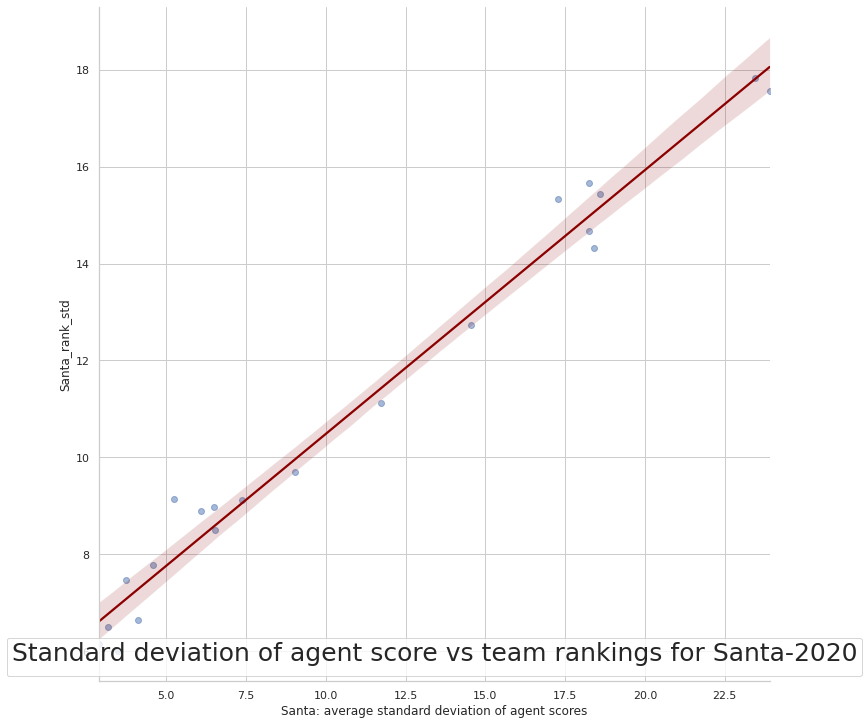

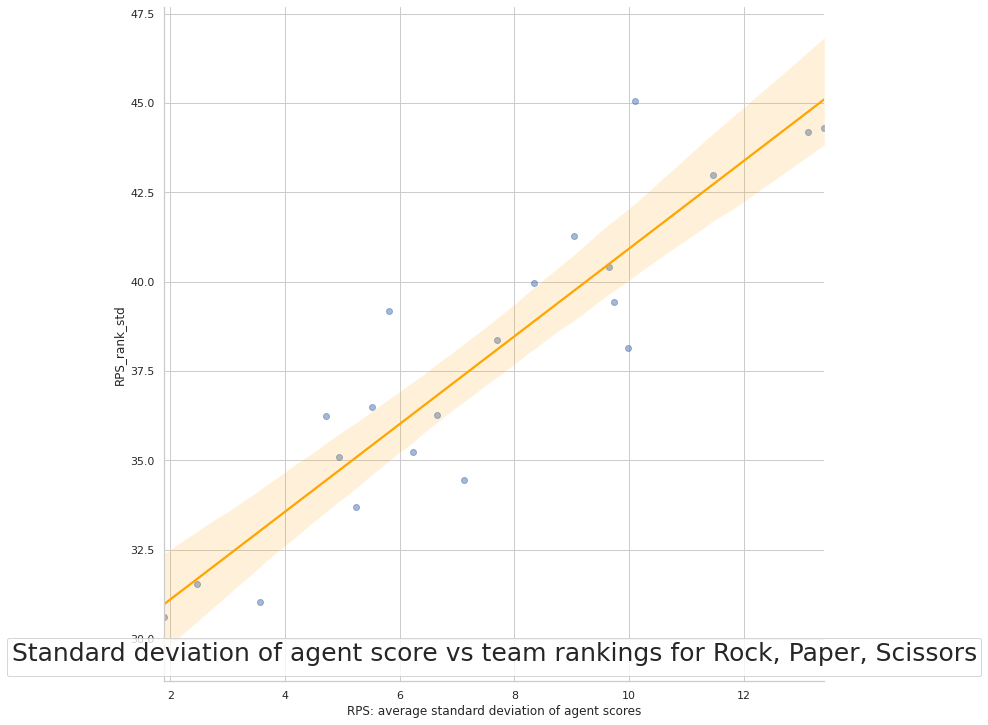

In [12]:
date_stat = pd.merge(date_stat, date_stat_agent, on = "date")
sns.set(style="whitegrid")
sns.lmplot("Santa: average standard deviation of agent scores", "Santa_rank_std", data=date_stat, scatter_kws={"alpha": 0.5}, line_kws={"color": "darkred"}, height=10)
plt.legend(title="Standard deviation of agent score vs team rankings for Santa-2020", loc="lower center", title_fontsize = 25)
plt.show()

sns.set(style="whitegrid")
sns.lmplot("RPS: average standard deviation of agent scores", "RPS_rank_std", data=date_stat, scatter_kws={"alpha": 0.5}, line_kws={"color": "orange"}, height=10)
plt.legend(title="Standard deviation of agent score vs team rankings for Rock, Paper, Scissors", loc="lower center", title_fontsize = 25)
plt.show()
del date_stat_agent

# 4. Volatility drivers: games per submission 

There are two sources of agent score volatility: number of games per day and confidence parameter (sigma, or *uncertainty of the estimate*). During the competition new submissions had a privilege (a large number of games on the first day), which caused high volatility for them. In the evaluation period new submissions are frozen, so this is not the case.

*NB: data for the last day is incomplete*

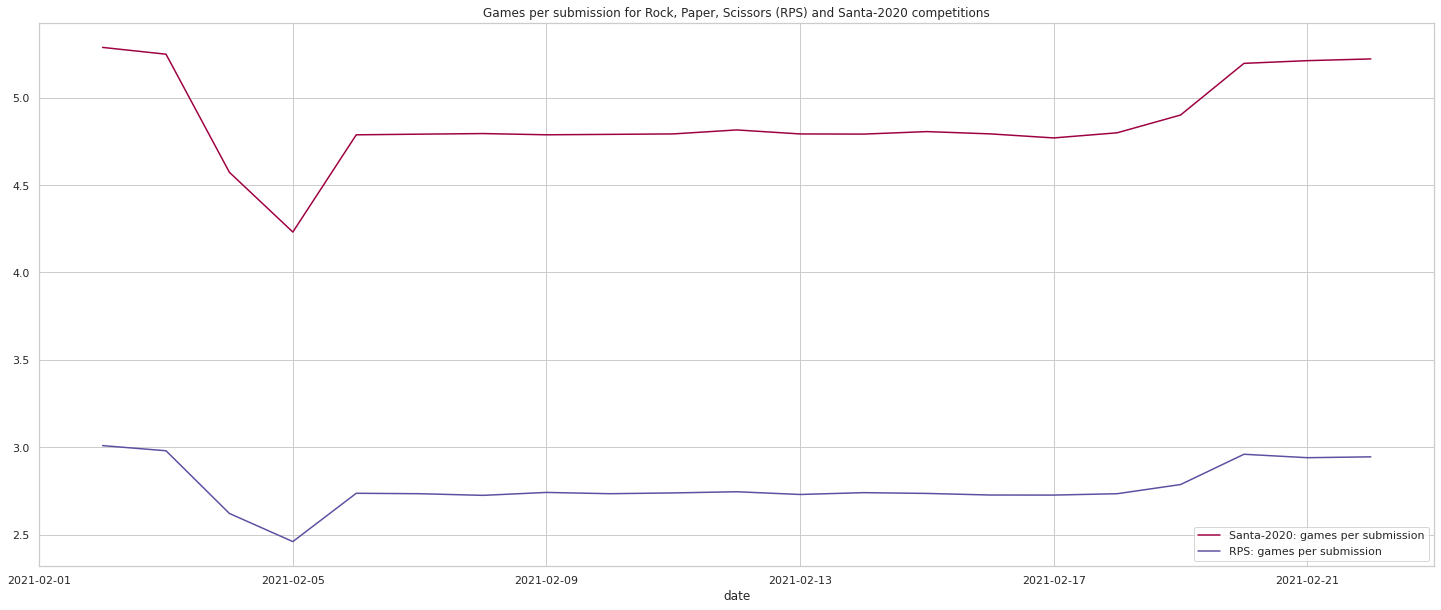

In [13]:
pd.merge(
        santa_df[santa_df["CreateTime"] >= pd.to_datetime('2021-02-02', format='%Y-%m-%d')].\
            groupby(["SubmissionId", "date"])["EpisodeId"].count().reset_index().\
            groupby("date")["EpisodeId"].mean().reset_index().rename(columns={"EpisodeId": "Santa-2020: games per submission"}),
        rps_df[rps_df["CreateTime"] >= pd.to_datetime('2021-02-02', format='%Y-%m-%d')].\
            groupby(["SubmissionId", "date"])["EpisodeId"].count().reset_index().\
            groupby("date")["EpisodeId"].mean().reset_index().rename(columns={"EpisodeId": "RPS: games per submission"}),
    on = "date").set_index("date").plot(figsize=(25,10), cmap="Spectral",
               title="Games per submission for Rock, Paper, Scissors (RPS) and Santa-2020 competitions")
plt.show()

# 5. Volatility drivers: confidence

Environment rules says:
> Each Submission has a rating which is modeled by a Gaussian N(μ,σ2) where μ is the estimated skill and σ represents our uncertainty of that estimate.

Confidence (sigma, σ) is calculated by the scoring system, based on how surprising were the game results.

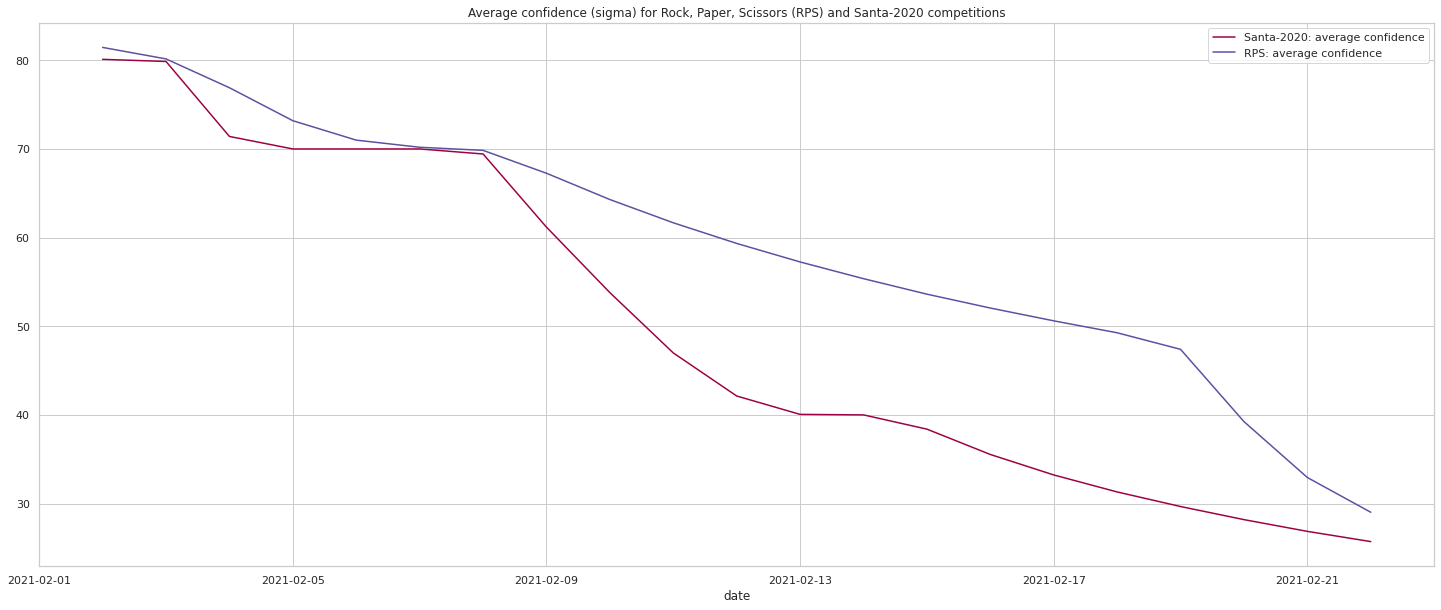

In [14]:
av_conf_stat = pd.merge(
                        santa_df[santa_df["CreateTime"] >= pd.to_datetime('2021-02-02', format='%Y-%m-%d')].\
                            groupby("date")["UpdatedConfidence"].mean().reset_index().rename(columns={"UpdatedConfidence": "Santa-2020: average confidence"}),
                        rps_df[rps_df["CreateTime"] >= pd.to_datetime('2021-02-02', format='%Y-%m-%d')].\
                            groupby("date")["UpdatedConfidence"].mean().reset_index().rename(columns={"UpdatedConfidence": "RPS: average confidence"}),
                    on = "date")
av_conf_stat.set_index("date").plot(figsize=(25,10), cmap="Spectral",
             title="Average confidence (sigma) for Rock, Paper, Scissors (RPS) and Santa-2020 competitions")
plt.show()

The number of games per day is more or less stable, whereas confidence (sigma) is falling. It's quite clear, that confidence is the major driver of agent score volatility:

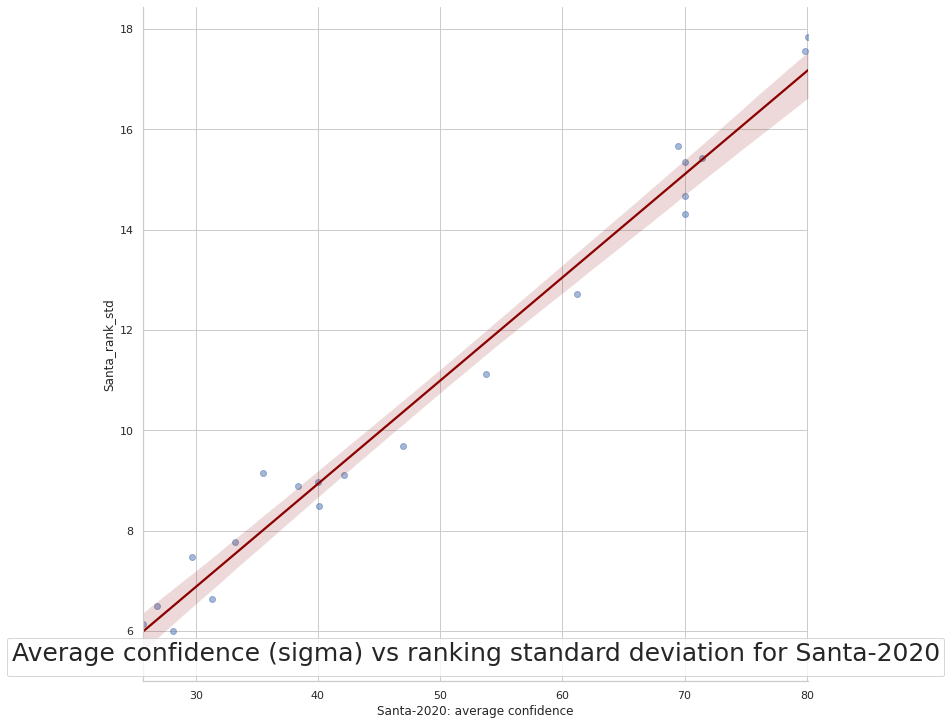

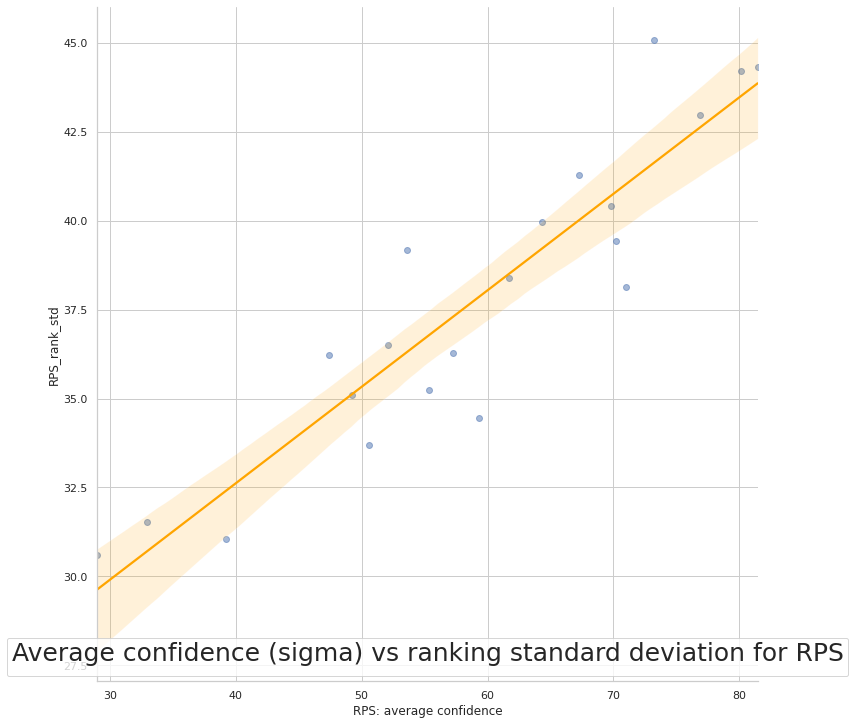

In [15]:
date_stat = pd.merge(date_stat, av_conf_stat, on = "date")
sns.set(style="whitegrid")
sns.lmplot("Santa-2020: average confidence", "Santa_rank_std", 
           data=date_stat, scatter_kws={"alpha": 0.5}, line_kws={"color": "darkred"}, height=10)
plt.legend(title="Average confidence (sigma) vs ranking standard deviation for Santa-2020", loc="lower center", title_fontsize = 25)
sns.set(style="whitegrid")
sns.lmplot("RPS: average confidence", "RPS_rank_std", 
           data=date_stat, scatter_kws={"alpha": 0.5}, line_kws={"color": "orange"}, height=10)
plt.legend(title="Average confidence (sigma) vs ranking standard deviation for RPS", loc="lower center", title_fontsize = 25)
plt.show()

Aside from the usual confidence downfall (which is built in the scoring system), there is an effect of adjustments. Precisely, the kaggle team [is decreasing minimum confidence](https://www.kaggle.com/c/santa-2020/discussion/215797#1181491):

> We increase minimum confidence at the start of the closing period for each simulation competition and then decrease minimum confidence throughout the week to encourage movement among stale submissions during competition close -- especially submissions that suffered from a bad leaderboard path.

In several discussions reduction of sigma was compared to [dropping the temperature](https://www.kaggle.com/c/rock-paper-scissors/discussion/213461#1191532). This effect is more noticeable if look from the start of the competition:

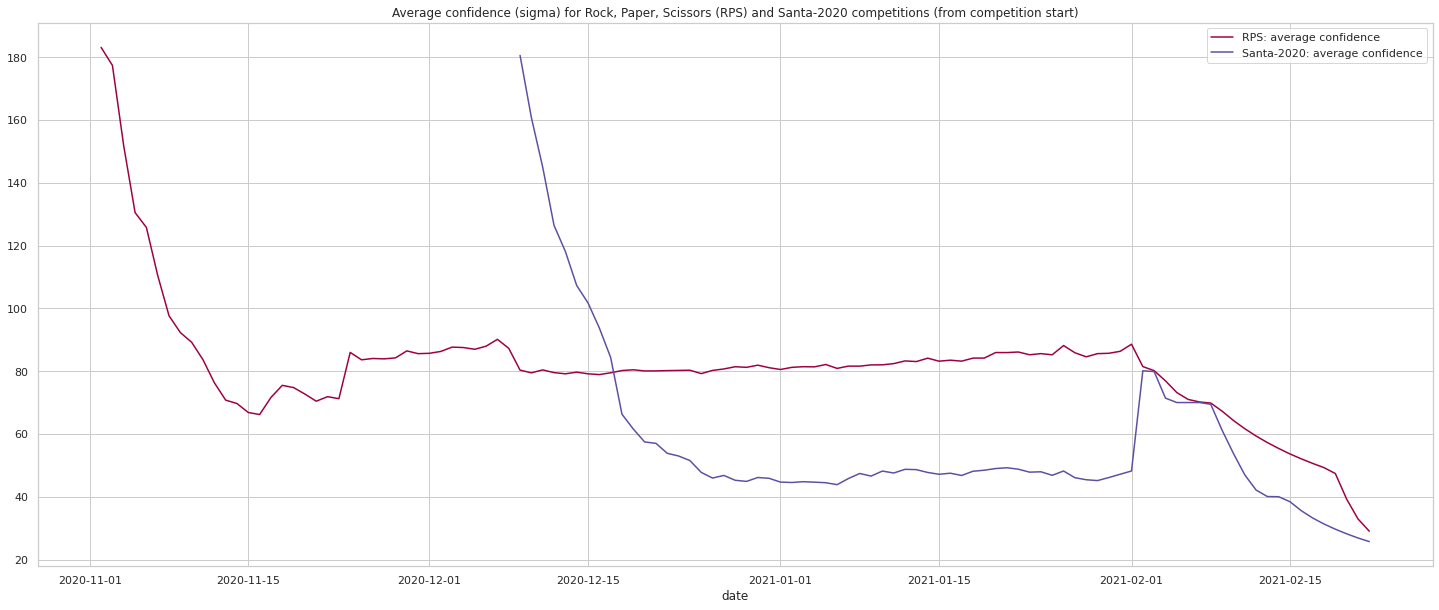

In [16]:
av_conf_stat = pd.merge(
                         rps_df.groupby("date")["UpdatedConfidence"].mean().reset_index().\
                            rename(columns={"UpdatedConfidence": "RPS: average confidence"}),                        
                        santa_df.groupby("date")["UpdatedConfidence"].mean().reset_index().\
                            rename(columns={"UpdatedConfidence": "Santa-2020: average confidence"}),
                    on = "date", how="left")
av_conf_stat.set_index("date").plot(figsize=(25,10), cmap="Spectral",
             title="Average confidence (sigma) for Rock, Paper, Scissors (RPS) and Santa-2020 competitions (from competition start)")
plt.show()
del av_conf_stat

However, in this visualization effect of adjustments is almost non-existent for RPS competition. 

As an alternative, we can look at confidence grouped by submission date ([@stassl](https://www.kaggle.com/stassl) got the idea of such analytics). Each line in the plot represents average confidence for submissions made on a specific date. That is, every line starts from the date of submission and goes up to the last day (although it gets overlapped by newer lines).

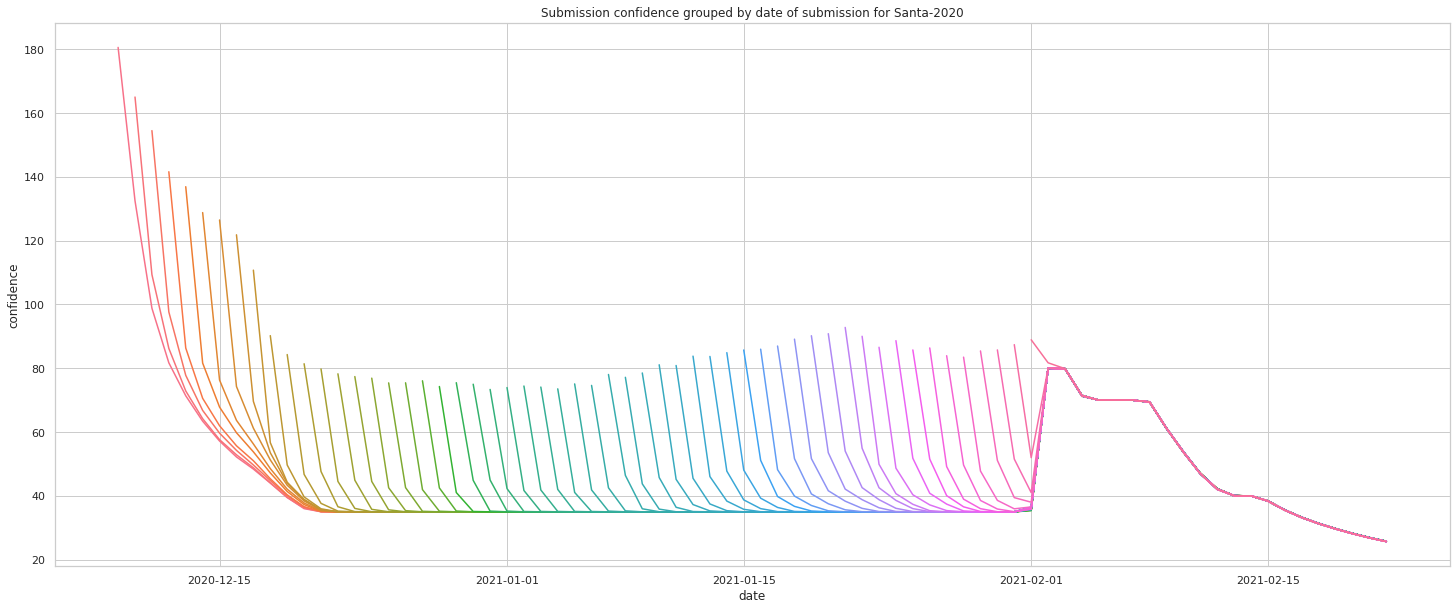

In [17]:
santa_df["submission_dt"] = santa_df["submission_dt"].dt.date
santa_conf_by_day = santa_df.groupby(["submission_dt", "date"])["UpdatedConfidence"].mean().reset_index().rename(columns={"UpdatedConfidence": "confidence"})
plt.figure(figsize=(25, 10))
sns.lineplot(data=santa_conf_by_day, x="date", y="confidence", hue="submission_dt", legend=False).\
    set_title("Submission confidence grouped by date of submission for Santa-2020")
plt.show()
del santa_conf_by_day

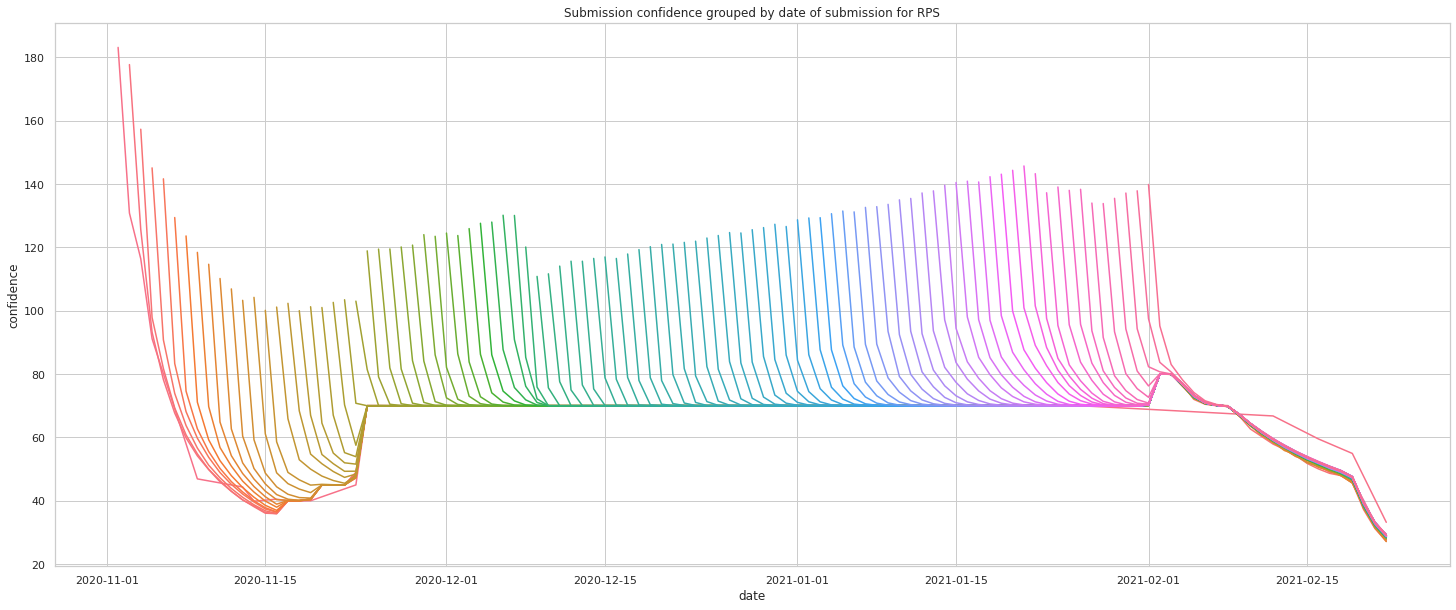

In [18]:
rps_df["submission_dt"] = rps_df["submission_dt"].dt.date
rps_conf_by_day = rps_df.groupby(["submission_dt", "date"])["UpdatedConfidence"].mean().reset_index().rename(columns={"UpdatedConfidence": "confidence"})
plt.figure(figsize=(25, 10))
sns.lineplot(data=rps_conf_by_day, x="date", y="confidence", hue="submission_dt", legend=False).\
    set_title("Submission confidence grouped by date of submission for RPS")
plt.show()
del rps_conf_by_day

To sum up, as result of sigma adjustments the system is heading to equilibrium for both RPS and Santa-2020. 